# # SKN 19기 mini-project 5팀(팀명: 여권어디있지) M/L

## ## 필수 라이브러리 import

In [64]:
# !pip install lightgbm
# !pip install optuna
# !pip install xgboost

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# pandas 출력 옵션
pd.set_option('display.float_format', '{:.2f}'.format)


# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

## ## 인코딩 저장, 불러오기 (Steamlit에서 불러오기 용도)

In [66]:
#------------------------------------------------------------
# 인코딩 저장, 불러오기
#------------------------------------------------------------

import json
from sklearn.preprocessing import LabelEncoder
import pathlib
import numpy as np

def save_encoding(encoder_name: str, encoder_obj: LabelEncoder):
    file_path = "./assets/" + encoder_name + ".json"
    p = pathlib.Path(file_path)
    directory_path = p.parent
    directory_path.mkdir(parents=True, exist_ok=True)

    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(encoder_obj.classes_.tolist(), f, ensure_ascii=False, indent=4)
    print(f'파일: {file_path} 저장완료')


def load_encoding(file_path: str):
    # file_path = "./assets/" + encoder_name + ".json"
    p = pathlib.Path(file_path)

    if not p.exists():
        print(f"오류: 파일 {file_path} 를 찾을 수 없습니다.")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            classes_list = json.load(f)        
        encoder_obj = LabelEncoder()
        encoder_obj.classes_ = np.array(classes_list)  # numpy 배열로 변환
        
        print(f'파일: {file_path} 로부터 인코더 로드 완료')
        return encoder_obj
        
    except json.JSONDecodeError:
        print(f"오류: 파일 {file_path} 의 JSON 형식이 올바르지 않습니다.")
        return None
    except Exception as e:
        print(f"인코더 로드 중 알 수 없는 오류 발생: {e}")
        return None

## ## 모델 평가용 메서드

In [67]:
# 다른 평가 지표
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# 회귀를 평가하는 함수
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true,y_pred)
    rmse = root_mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

## ## 파일 로드

In [68]:
df_listings = pd.read_csv('./data/listings_cleaned_1st.csv')
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22983 entries, 0 to 22982
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   neighbourhood_cleansed      22983 non-null  object 
 1   property_type               22983 non-null  object 
 2   room_type                   22983 non-null  object 
 3   accommodates                22983 non-null  int64  
 4   bathrooms                   22983 non-null  float64
 5   bedrooms                    22983 non-null  float64
 6   beds                        22983 non-null  float64
 7   price                       22983 non-null  float64
 8   number_of_reviews           22983 non-null  int64  
 9   first_review                19865 non-null  object 
 10  review_scores_rating        19865 non-null  float64
 11  amnt_self_checkin           22983 non-null  int64  
 12  amnt_instant_book           22983 non-null  int64  
 13  amnt_kitchen                229

## ## 데이터 변환 및 피처 엔지니어링

In [69]:
""" 라벨인코딩은 원핫인코딩으로 대체


# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

le_neighbourhood_cleansed = LabelEncoder()
le_property_type = LabelEncoder()
le_room_type = LabelEncoder()

df_listings["neighbourhood_cleansed"] = le_neighbourhood_cleansed.fit_transform(df_listings["neighbourhood_cleansed"])
df_listings["property_type"] = le_property_type.fit_transform(df_listings["property_type"])
df_listings["room_type"] = le_room_type.fit_transform(df_listings["room_type"])

# 인코딩 저장 = predict 용도
save_encoding('le_neighbourhood_cleansed',le_neighbourhood_cleansed)
save_encoding('le_property_type',le_property_type)
save_encoding('le_room_type',le_room_type)"""


from sklearn.preprocessing import LabelEncoder

le_neighbourhood_cleansed = LabelEncoder()
le_property_type = LabelEncoder()
le_room_type = LabelEncoder()

df_listings["neighbourhood_cleansed"] = le_neighbourhood_cleansed.fit_transform(df_listings["neighbourhood_cleansed"])
df_listings["property_type"] = le_property_type.fit_transform(df_listings["property_type"])
df_listings["room_type"] = le_room_type.fit_transform(df_listings["room_type"])





In [70]:
# 피처 엔지니어링

# days_since_first_review 추가
if False:
    df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors='coerce')
    reference_date = pd.to_datetime('2025-06-27')
    df_listings['days_since_first_review'] = (reference_date - df_listings['first_review']).dt.days

In [71]:
# 추가 드롭 목록

# 드롭 목록
drop_list = [
    'number_of_reviews',    # 리뷰 갯수
    'first_review',          # 첫 리뷰 일자
    #'review_scores_rating',
    # 'review_scores_rating'
]

df_listings = df_listings.drop(drop_list, axis=1)

## ## 모델 학습 및 평가

In [72]:
# feature, label 데이터 분리,
# 학습, 평가 데이터 분리

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import optuna
from optuna.logging import WARNING, ERROR


x = df_listings.drop('price', axis=1)
y = df_listings['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [73]:
# lightgbm은 트리 기반이라 스케일링 후 성능이 더 떨어짐

# x 데이터 스케일링 

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


# price가 너무 커서 로그 처리함
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
# 하이퍼 파라미터 최적화

def print_optimized_hyper_params(X, y):

    def lgbm_optuna_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }

        lgbm_reg = LGBMRegressor(**params, n_jobs=-1)
        mean_r2 = cross_val_score(lgbm_reg, X, y, scoring='r2', cv=3).mean()
        return mean_r2
    
    optuna.logging.set_verbosity(ERROR) 

    # 2. study 객체 -> 최적화
    study = optuna.create_study(direction="maximize")
    study.optimize(lgbm_optuna_objective, n_trials=100)
    # 3. 결과 출력

    return study.best_value, study.best_params

best_value, best_params = None, None

In [ ]:

# 마지막 실행 결과

# 0.6922601916488733 {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.07550817249873713, 'colsample_bytree': 0.7168073346888015}

#------------------------------------------------------------
# optuna 돌릴때 아래 부분 주석 해제
#------------------------------------------------------------
# best_value, best_params = print_optimized_hyper_params(X_train, y_train)

# print(best_value, best_params)

# n_estimators_optuna = best_params['n_estimators']
# max_depth_optuna = best_params['max_depth']
# learning_rate_optuna = best_params['learning_rate']
# colsample_bytree_optuna = best_params['colsample_bytree']

n_estimators_optuna = 500
max_depth_optuna = 10
learning_rate_optuna = 0.07550817249873713
colsample_bytree_optuna = 0.7168073346888015

None None


In [76]:
# 교차 검증

lgbm_reg = LGBMRegressor(n_estimators=n_estimators_optuna,  # 트리의 개수
                         max_depth=max_depth_optuna,
                         learning_rate=learning_rate_optuna, # 학습률
                        #  random_state=42,
                         colsample_bytree=colsample_bytree_optuna,
                         force_row_wise=True, 
                         n_jobs=-1) # 모든 코어 사용

cv_results = cross_validate(
    lgbm_reg,
    X_train,
    y_train,
    cv=5, 
    scoring='r2',
    return_estimator=True
)

# print("훈련별 정확도:", scores)
# print("모델 정확도:", np.mean(scores))



[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 14708, number of used features: 32
[LightGBM] [Info] Start training from score 9.588624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 14709, number of used features: 32
[LightGBM] [Info] Start training from score 9.584490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [77]:
# 교차 검증 최상위 모델 저장

# R2 점수가 가장 높게 나온 폴드 인덱스
best_r2_index = np.argmax(cv_results['test_score'])

# 가장 좋은 성능을 낸 모델을 변수에 저장합니다.
best_model = cv_results['estimator'][best_r2_index]

print(f"최고 R2 점수: {cv_results['test_score'][best_r2_index]:.4f}")
# print("최고 성능 모델이 'best_model' 변수에 저장되었습니다.")

최고 R2 점수: 0.7079


In [78]:
# 최상위 모델 학습

best_model.fit(X_train, y_train, categorical_feature=['neighbourhood_cleansed', 'property_type', 'room_type'])
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 18386, number of used features: 32
[LightGBM] [Info] Start training from score 9.587909


In [79]:
evaluate_regression(y_train,y_pred_train)
evaluate_regression(y_test,y_pred_test)

MSE: 0.06971347783062289, RMSE: 0.2640330998769338, MAE: 0.19832162944520165, R2: 0.8088767077567804
MSE: 0.10742882453202705, RMSE: 0.32776336667179123, MAE: 0.2468595978094449, R2: 0.7182466741639241


In [80]:
from joblib import dump

r2 = r2_score(y_test,y_pred_test)
r2_truncated = int(r2 * 100) / 100.0

# 첫번째 인자: 모델
# 두번째 인자: 파일명
dump(best_model, f'model_LGBMReg_r2_test_{r2_truncated}.jobilb') # 모델 저장

['model_LGBMReg_r2_test_0.71.jobilb']

## ## 결과 확인

In [81]:
import json
amenities = './data/amenities.json'
columns = './data/columns.json'


# 📂 불러오기 (Reading)
with open(amenities, 'r', encoding='utf-8') as f:
    amenity_eng_to_kor = json.load(f)

with open(columns, 'r', encoding='utf-8') as f:
    columns_ori = json.load(f)

# 한글-영어 매핑 딕셔너리 (반대 변환용)
# amenity_kor_to_eng = {v: k for k, v in amenity_eng_to_kor.items()}



In [82]:
# 스코어 컬럼 남기기
columns_kor = [amenity_eng_to_kor.get(col.replace('amnt_',''), col) for col in X_train.columns]
columns_kor = [columns_ori.get(col.replace('amnt_',''), col) for col in columns_kor]


columns_kor
# columns_kor = 

['정제된 숙소 지역 이름',
 '숙소의 종류',
 '숙소의 방 유형',
 '숙소가 수용 가능한 최대 인원 수',
 '숙소의 욕실 개수',
 '숙소의 침실 개수',
 '숙소의 침대 개수',
 '총 리뷰 점수(별점)의 평균값',
 '셀프 체크인',
 '즉시예약',
 '주방',
 '헤어드라이어',
 '무료 주차 공간',
 '와이파이',
 '침실에 딸린 개인 욕실',
 '바베큐 그릴',
 '세탁기',
 '반려동물 동반 가능',
 '건조기',
 '난방',
 '냉방',
 '업무 전용 공간',
 '다리미',
 '수영장',
 '대형 욕조',
 '전기차 충전시설',
 '아기 침대',
 '킹사이즈 침대',
 '헬스장',
 '조식',
 '실내 벽난로',
 '흡연 가능',
 '수변',
 '화재경보기',
 '일산화탄소 경보기']

In [83]:
# importances

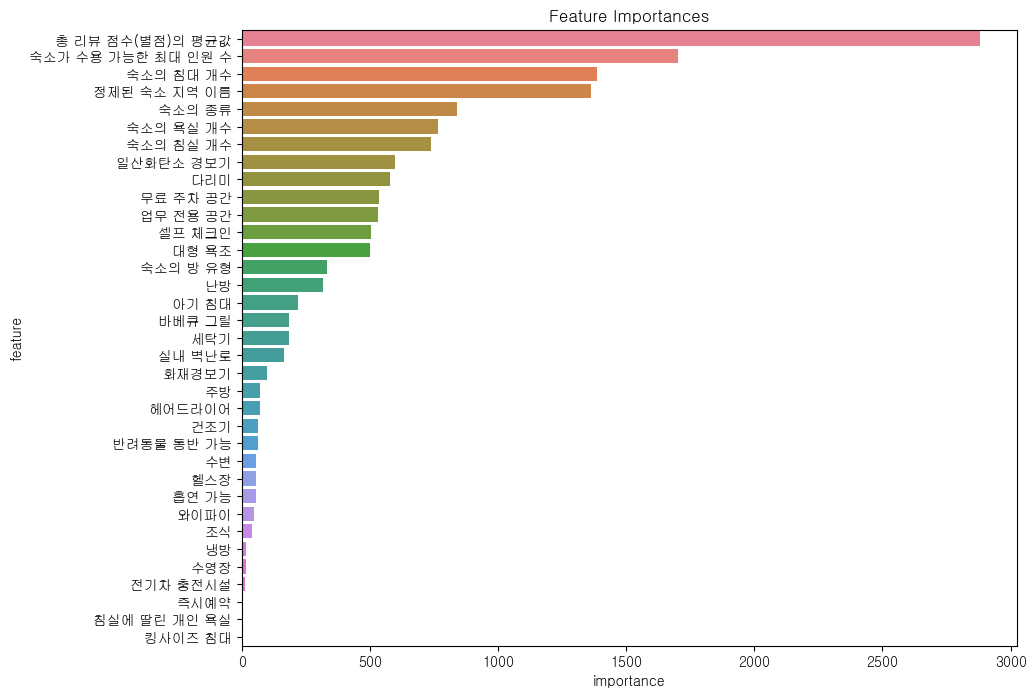

In [84]:
# DataFrame으로 생성
importances = pd.DataFrame({
    # 'feature': X_train.columns,
    'feature': columns_kor,
    'importance': best_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False, ignore_index=True)


# DataFrame 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=importances, x='importance', y='feature', hue='feature')
plt.title('Feature Importances')
plt.show()